In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Projects/GO_GO_Nihongo/ocr

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/14kN-FziW24aUnE1LuiZ3m2W5UaK7G2vt/GO_GO_Nihongo/ocr


In [ ]:
from IPython.display import clear_output
%pip install manga-ocr
%pip install easyocr
%pip install prettytable
%pip install opencv-python-headless
%pip install pillow
clear_output()

In [ ]:
import easyocr
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable

def display_dataframe(ocr_data):
    # Create a DataFrame
    df = pd.DataFrame(ocr_data, columns=["Text", "Confidence", "Bounding Box"])

    # Display the DataFrame using PrettyTable
    # Convert df.columns (Pandas Index) to a list
    table = PrettyTable(list(df.columns))  # Set the table headers

    for row in df.itertuples(index=False, name=None):  # Iterate over the DataFrame rows
        table.add_row(row)  # Add each row to the table

    # Print the formatted table
    print(table)


def draw_bounding_boxes(image, results):
    """
    Draws bounding boxes on the image for each detected text.
    """
    for (bbox, text, confidence) in results:
        # Convert coordinates to integers
        bbox_int = [(int(coord[0]), int(coord[1])) for coord in bbox]
        top_left = bbox_int[0]  # top-left corner
        bottom_right = bbox_int[2]  # bottom-right corner
        image = cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
        image = cv2.putText(image, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    return image

def is_inside(small_box, large_box):
    """Check if the small bounding box is inside the large bounding box."""
    return (large_box[0][0] <= small_box[0][0] and
            large_box[0][1] <= small_box[0][1] and
            large_box[2][0] >= small_box[2][0] and
            large_box[2][1] >= small_box[2][1])

def filter_bboxes(detected_bbox):
    """Filter out bounding boxes that are completely inside other bounding boxes."""
    filtered_bbox = []
    for i, bbox in enumerate(detected_bbox):
        inside_another = any(is_inside(bbox, other_bbox) for j, other_bbox in enumerate(detected_bbox) if i != j)
        if not inside_another:
            filtered_bbox.append(bbox)
    return filtered_bbox


In [ ]:
# Initialize easyocr Reader for Japanese (ja) language
reader = easyocr.Reader(['ja'], gpu=False)  # Set gpu=True if you have a compatible GPU


def easyocr_detection(image_path,is_print=True):
    image = cv2.imread(image_path)

    # Perform OCR on the image
    results = reader.readtext(image_path)

    detected_bbox = []
    ocr_data = []  # List to store the OCR results for the DataFrame

    # Collect results in a DataFrame-friendly format
    for bbox, text, confidence in results:
        detected_bbox.append(bbox)

    # Filter out small bounding boxes inside larger ones
    detected_bbox = filter_bboxes(detected_bbox)

    if is_print:
      # Collect results in a DataFrame-friendly format
      for bbox, text, confidence in results:
          confidence = round(confidence, 4)
          bbox_int = [(int(coord[0]), int(coord[1])) for coord in bbox]
          ocr_data.append([text, confidence, bbox_int])

      # Display the OCR results in a formatted table
      display_dataframe(ocr_data)

      # Draw bounding boxes on the image
      image_with_boxes = draw_bounding_boxes(image, results)

      # Display the image with matplotlib
      plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.show()

    return detected_bbox

+-------------------------+------------+------------------------------------------------------+
|           Text          | Confidence |                     Bounding Box                     |
+-------------------------+------------+------------------------------------------------------+
|           _1乙          |   0.0502   |     [(454, 18), (568, 18), (568, 42), (454, 42)]     |
|      "ゆ 紀炉‥きり      |   0.0003   |     [(503, 61), (579, 61), (579, 73), (503, 73)]     |
|        稲葉みのり       |   0.6693   |     [(480, 72), (586, 72), (586, 98), (480, 98)]     |
|            職           |   0.0032   |    [(598, 88), (774, 88), (774, 328), (598, 328)]    |
|            1            |   0.679    |   [(755, 117), (788, 117), (788, 368), (755, 368)]   |
|         @らなロ         |   0.0672   |   [(119, 347), (177, 347), (177, 367), (119, 367)]   |
| が上さんのガチひが充に! |   0.0153   |   [(117, 365), (255, 365), (255, 385), (117, 385)]   |
|     ハレという現奥に    |   0.1446   |   [(140, 381), (231, 381), (231, 

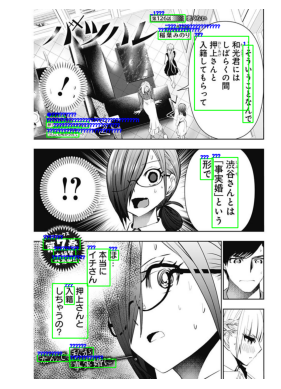

In [ ]:
# Load the image with OpenCV (or use a file path directly with easyocr)
image_path = './1.jpg'
detected_bbox = easyocr_detection(image_path)

In [ ]:
import easyocr
import cv2
import matplotlib.pyplot as plt


def crop_detected_section(image_path, bbox):
    """
    Crops the detected sections of the image based on bounding boxes.
    """

    image = cv2.imread(image_path)
    # Convert bounding box coordinates to integers
    x1, y1 = int(bbox[0][0]), int(bbox[0][1])
    x2, y2 = int(bbox[2][0]), int(bbox[2][1])

    # Crop the image section
    cropped_section = image[y1:y2, x1:x2]

    return cropped_section


def show_cropped_images(cropped_images):
    """
    Displays the cropped images using matplotlib.pyplot.

    Args:
        cropped_images (list): List of cropped image sections (NumPy arrays).
    """

    num_images = len(cropped_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Adjust figsize as needed

    for i, image in enumerate(cropped_images):
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
        axes[i].axis('off')  # Turn off axis labels

    plt.show()

In [ ]:
cropped_images = [crop_detected_section(image_path, bbox) for bbox in detected_bbox]
show_cropped_images(cropped_images)

In [ ]:

from manga_ocr import MangaOcr
import cv2
import numpy as np
from PIL import Image  # Import the Image class from PIL

# Initialize the MangaOcr instance
ocr = MangaOcr()

def apply_manga_ocr(section):
    """Applies MangaOcr to a section of an image.

    Args:
        section: A NumPy array representing the image section.

    Returns:
        The extracted text from the image section.
    """

    # Convert section to a compatible image format (e.g., BGR)
    if section.dtype != np.uint8:
        section = (section * 255).astype(np.uint8)

    if len(section.shape) == 2:
        image = cv2.cvtColor(section, cv2.COLOR_GRAY2BGR)
    elif section.shape[2] == 4:  # RGBA image (with alpha channel)
        image = cv2.cvtColor(section, cv2.COLOR_RGBA2BGR)
    else:
        image = section

    # Convert the NumPy array to a PIL Image object
    image = Image.fromarray(image)


    # plt.imshow(np.array(image))
    # plt.axis('off')  # Hide axes
    # plt.show()

    # Extract text from the image
    text = ocr(image)

    return text
clear_output()

In [ ]:
extracted_text=[apply_manga_ocr(cropped_section) for cropped_section in cropped_images]
extracted_text

['第１２６話が第',
 '全１６委員会案中',
 '稲葉みのり',
 '．．．そういうことだ、和光君にはしばらくの間押上さんと入籍してもらって',
 '．そういうことなんで',
 '．．．',
 '押しきんのガチ恋が発覚に',
 'アハレという現象に',
 'ついても明かされて',
 '形で',
 '渋谷さんとは「事実婚」という',
 'ほ',
 '本当にイチさん',
 '押上さんと入籍しちゃうの？',
 '私が',
 '第７条',
 '大組織',
 '．．．',
 'そんで、',
 '重実増に']

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# Load the pre-trained MarianMT model and tokenizer for Japanese to English translation
model_name = 'Helsinki-NLP/opus-mt-ja-en'
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Function to translate Japanese to English
def translate_japanese_to_english(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True)

    # Perform the translation
    translated = model.generate(**inputs)

    # Decode the translated text
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_text

clear_output()

In [ ]:
translated_texts=[translate_japanese_to_english(japanese_text) for japanese_text in extracted_text]
translated_texts

['I want to talk to you about the 126th.',
 "We're in the middle of 16 committees.",
 'Iseshima.',
 "That's right.",
 "That's what I'm talking about.",
 '...',
 "I'm in love with you. I'm in love with you.",
 "It's a phenomenon called Harare.",
 "I've been made clear.",
 'In shape.',
 'Shibuya-san and I are actually married.',
 'Hey.',
 "I'm so sorry, I'm so sorry.",
 'Are you going to join Mr. Pushe?',
 "I'll take care of it.",
 'Article 7',
 'A large organization.',
 '...',
 '(Laughter)',
 "It's a lot worse than that."]

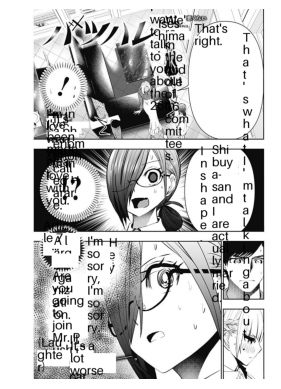

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import textwrap

def replace_rectangles_with_white(image_path, ocr_bboxes, texts, font_path='./NotoSansJP-Regular.ttf', font_size=40):
    """
    Replace specified OCR-detected rectangular regions with white color in an image.

    Parameters:
    - image_path (str): Path to the input image.
    - ocr_bboxes (list of list): List of bounding boxes from OCR, where each box is a list of points.
    - texts (list of str): List of text labels to draw above each rectangle.
    - font_path (str): Path to the Japanese font file.
    - font_size (int): Font size for text labels.

    Returns:
    - Image object with specified rectangles replaced by white.
    """
    # Open the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # # Load the Japanese font with the specified size
    # try:
    #     font = ImageFont.truetype(font_path, font_size)
    # except IOError:
    #     print("Font not found. Using default font, which may not support Japanese characters.")
    #     font = ImageFont.load_default(size = font_size)  # Fallback to default if the font file isn't available

    font = ImageFont.load_default(size = font_size)

    # Convert OCR polygon bounding boxes to rectangles and draw them
    for bbox, text in zip(ocr_bboxes, texts):
        # Flatten and find min/max to convert polygon to bounding rectangle
        x_coords, y_coords = zip(*bbox)
        x1, y1, x2, y2 = min(x_coords), min(y_coords), max(x_coords), max(y_coords)
        draw.rectangle([x1, y1, x2, y2], fill="white")

        # Wrap text based on rectangle width
        max_text_width = x2 - x1
        wrapped_text = textwrap.fill(text, width=int(max_text_width / font_size * 1.8))

        # Draw each line of wrapped text
        text_y_position = y1 - font_size - 10  # Start position for text
        for line in wrapped_text.splitlines():
            draw.text((x1, text_y_position), line, fill="black", font=font)
            text_y_position += font_size  # Move down for the next line

    return image

result_image = replace_rectangles_with_white(image_path, detected_bbox, translated_texts)
# Display the result
plt.imshow(result_image)
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image


def combined_function(image_path):
    detected_bbox = easyocr_detection(image_path,is_print=False)
    cropped_images = [crop_detected_section(image_path, bbox) for bbox in detected_bbox]
    extracted_text=[apply_manga_ocr(cropped_section) for cropped_section in cropped_images]
    translated_texts=[translate_japanese_to_english(japanese_text) for japanese_text in extracted_text]
    result_image = replace_rectangles_with_white(image_path, detected_bbox, translated_texts,font_size=20)
    return result_image


def show_result(image_path):
    # Assuming combined_function and result_image are defined
    result_image = combined_function(image_path)
    original_image = Image.open(image_path)

    # Plotting the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Displaying the original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")  # Hide axes for a cleaner look

    # Displaying the result image
    axes[1].imshow(result_image)
    axes[1].set_title("Result Image")
    axes[1].axis("off")  # Hide axes for a cleaner look

    plt.tight_layout()
    plt.show()

show_result("./2.jpg")
